<a href="https://colab.research.google.com/github/louiezzang/nextmining-forecasting/blob/main/notebooks/DeepAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/louiezzang/nextmining-forecasting.git

  Cloning https://github.com/louiezzang/nextmining-forecasting.git to /tmp/pip-req-build-_x8mvyqy
  Running command git clone --filter=blob:none --quiet https://github.com/louiezzang/nextmining-forecasting.git /tmp/pip-req-build-_x8mvyqy
  Resolved https://github.com/louiezzang/nextmining-forecasting.git to commit 1c20e0578988f68901cc7741dd7f0af89274af70
  Preparing metadata (setup.py) ... done


In [2]:
import time
import gc
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler
import torch.optim as optim
from torch import nn
import torchvision
import torch

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from forecasting.data import TimeSeriesDataset
from forecasting.models import DeepAR
import forecasting.models.deepar.net as net

In [3]:
def fit_preprocessing(train, real_columns, categorical_columns):
    real_scalers = StandardScaler().fit(train[real_columns].values)

    categorical_scalers = {}
    num_classes = []
    for col in categorical_columns:
        srs = train[col].apply(str)
        categorical_scalers[col] = LabelEncoder().fit(srs.values)
        num_classes.append(srs.nunique())

    return real_scalers, categorical_scalers


def transform_inputs(df, real_scalers, categorical_scalers, real_columns, categorical_columns):
    out = df.copy()
    out[real_columns] = real_scalers.transform(df[real_columns].values)

    for col in categorical_columns:
        string_df = df[col].apply(str)
        out[col] = categorical_scalers[col].transform(string_df)

    return out

In [4]:
class WebTrafficGenerator:
    def __init__(self, start_date="2021-01-01", end_date="2024-12-31", trend_base=0.5,
                 weekly_seasonality=None, yearly_seasonality=None, noise_multiplier=10):
        self.dates = dates = pd.date_range(start=start_date, end=end_date, freq="D")
        self.trend_base = trend_base
        self.weekly_seasonality = weekly_seasonality
        self.yearly_seasonality = yearly_seasonality
        self.noise_multiplier = noise_multiplier
        self.web_traffic = []

    def generate_data(self):

        day = 24 * 60 * 60
        week = day * 7
        year = 365.2425 * day

        if self.yearly_seasonality:
            yearly = ((1 + np.sin(self.dates.view("int64") // 1e9 * \
                                  (self.yearly_seasonality * np.pi / year))) * 100).astype(int)
        else:
            yearly = 0

        if self.weekly_seasonality:
            weekly = ((1 + np.sin(self.dates.view("int64") // 1e9 * \
                                  (self.weekly_seasonality * np.pi / week))) * 10).astype(int)
        else:
            weekly = 0

        trend = np.array(range(len(self.dates)))*self.trend_base
        noise = ((np.random.random(len(self.dates))-0.5)*self.noise_multiplier).astype(int)

        return trend+yearly+weekly+noise


(array([18628., 18809., 18993., 19174., 19358., 19539., 19723., 19905.,
        20089.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07'),
  Text(19723.0, 0, '2024-01'),
  Text(19905.0, 0, '2024-07'),
  Text(20089.0, 0, '2025-01')])

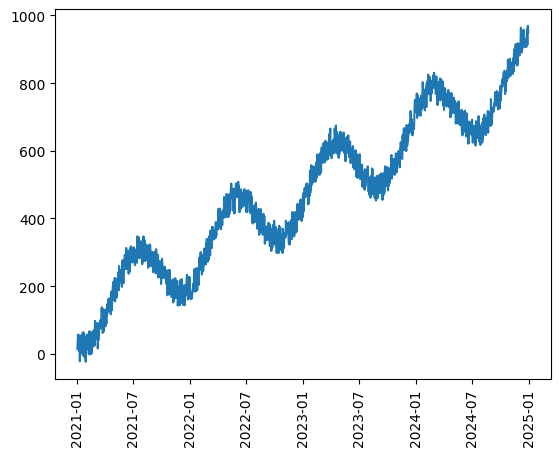

In [5]:
traffic_generator = WebTrafficGenerator(start_date="2021-01-01",
                                        end_date="2024-12-31",
                                        trend_base=0.5,
                                        weekly_seasonality=0.7,
                                        yearly_seasonality=2.3,
                                        noise_multiplier=80)
traffic = traffic_generator.generate_data()

plt.plot(traffic_generator.dates, traffic)
plt.xticks(rotation=90)

In [6]:
entities = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"]
groups = {"High": ["A", "B", "C", "D", "E"], "Medium": ["F", "G", "H", "I", "J", "K"], "Low": ["L", "M", "N", "O", "P"]}

In [7]:
raw = pd.DataFrame(columns=["date", "traffic", "Entity", "Class", "DayOfWeek", "DayOfMonth", "WeekOfYear", "Month", "Year"])

for e in entities:
    trend_base = np.round(np.random.random(), 2)

    if e in groups["High"]:
        trend_base *= 1.5
        group = "High"
    elif e in groups["Low"]:
        trend_base *= 0.7
        group = "Low"
    else:
        group = "Medium"

    traffic_generator = WebTrafficGenerator(start_date="2020-01-01",
                                            end_date="2024-12-31",
                                            trend_base=trend_base,
                                            weekly_seasonality=0.7 +np.round(np.random.uniform(0, 2.0), 2),
                                            yearly_seasonality=6.0 +np.round(np.random.uniform(0, 2.0), 2),
                                            noise_multiplier=80)

    traffic = traffic_generator.generate_data()
    tmp = pd.DataFrame(data={"date": traffic_generator.dates, "traffic":traffic})
    tmp["Entity"] = [e]*tmp.shape[0]
    tmp["Class"] = [group]*tmp.shape[0]
    tmp["DayOfWeek"] = tmp.date.dt.dayofweek
    tmp["DayOfMonth"] = tmp.date.dt.day
    tmp["WeekOfYear"] = tmp.date.dt.isocalendar().week
    tmp["Month"] = tmp.date.dt.month
    tmp["Year"] = tmp.date.dt.year
    tmp["DaysFromStart"] = np.arange(tmp.shape[0])
    tmp["Delta"] = tmp["traffic"].diff().fillna(0)

    raw = pd.concat([raw, tmp])

raw.reset_index(inplace=True)

(array([17897., 18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

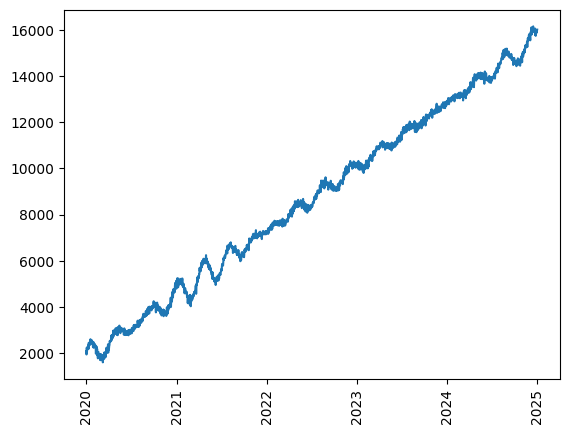

In [8]:
total = raw.groupby("date")["traffic"].sum()
plt.plot(total.index, total)
plt.xticks(rotation=90)

In [9]:
train = raw[raw["date"] < "2023-01-01"]
valid = raw.loc[(raw["date"] >= "2023-01-01") & (raw["date"] < "2024-01-01")]
test = raw.loc[(raw["date"] > "2024-01-01")]

In [10]:
real_columns = ["traffic", "Delta", "DaysFromStart"]
categorical_columns = ["Entity", "DayOfWeek", "DayOfMonth", "WeekOfYear", "Month", "Class"]

real_scalers, categorical_scalers = fit_preprocessing(train, real_columns, categorical_columns)

train = transform_inputs(train, real_scalers, categorical_scalers, real_columns, categorical_columns)
# valid = transform_inputs(valid, real_scalers, categorical_scalers, real_columns, categorical_columns)
test = transform_inputs(test, real_scalers, categorical_scalers, real_columns, categorical_columns)

In [11]:
# Global variables
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params = {
    "learning_rate": 1e-3,
    "batch_size": 64,
    "lstm_layers": 3,
    "num_epochs": 20,
    "train_window": 192,
    "test_window": 192,
    "predict_start": 168,
    "test_predict_start": 168,
    "predict_steps": 24,
    "num_class": 370,
    "cov_dim": 9,
    "lstm_hidden_dim": 40,
    "embedding_dim": 20,
    "sample_times": 200,
    "lstm_dropout": 0.1,
    "predict_batch": 256,
    "device": DEVICE,
}
ENCODER_STEPS = params["train_window"]
DECODER_STEPS = ENCODER_STEPS
BATCH_SIZE = params["batch_size"]

# Dataset variables
input_columns = ["traffic", "Delta", "DaysFromStart", "DayOfWeek", "DayOfMonth", "WeekOfYear", "Month", "Entity", "Class", "Entity"]
target_column = "traffic"
entity_column = "Entity"
time_column = "date"
col_to_idx = {col: idx for idx, col in enumerate(input_columns)}

In [12]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset


class TimeSeriesDatasetTest(Dataset):
    """
    Args:
        data (pd.DataFrame): dataframe containing raw data
        entity_column (str): name of column containing entity data
        time_column (str): name of column containing date data
        target_column (str): name of column we need to predict
        input_columns (list): list of string names of columns used as input
        encoder_steps (int): number of known past time steps used for forecast. Equivalent to size of LSTM encoder
        decoder_steps (int): number of input time steps used for each forecast date. Equivalent to the width N of the decoder
    """
    def __init__(self,
                 data: pd.DataFrame,
                 entity_column: str,
                 time_column: str,
                 target_column: str,
                 input_columns: list,
                 encoder_steps: int,
                 decoder_steps: int):
        self.encoder_steps = encoder_steps

        inputs = []
        outputs = []
        entity = []
        time = []

        # print(data[entity_column].unique())

        for e in data[entity_column].unique():
            entity_group = data[data[entity_column]==e]
        #   print(f"entity_group = {entity_group}")

            data_time_steps = len(entity_group)
            # print(f"data_time_steps = {data_time_steps}")

            if data_time_steps >= decoder_steps:
                x = entity_group[input_columns].values.astype(np.float32)
                inputs.append(np.stack([x[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

                y = entity_group[[target_column]].values.astype(np.float32)
                outputs.append(np.stack([y[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

                e = entity_group[[entity_column]].values.astype(np.float32)
                entity.append(np.stack([e[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

                t = entity_group[[time_column]].values.astype(np.int64)
                time.append(np.stack([t[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

        print(f"inputs = {inputs[0].shape}")
        print(f"outputs = {outputs[0].shape}")

        self.inputs = np.concatenate(inputs, axis=0)
        if decoder_steps > encoder_steps:
            self.outputs = np.concatenate(outputs, axis=0)[:, encoder_steps:, :]
        else:
            self.outputs = np.concatenate(outputs, axis=0)
        self.entity = np.concatenate(entity, axis=0)
        self.time = np.concatenate(time, axis=0)
        self.active_inputs = np.ones_like(outputs)

        print(f"self.inputs = {self.inputs[0].shape}")
        print(f"self.outputs = {self.outputs[0].shape}")

        # self.sampled_data = {
        #     "inputs": self.inputs,
        #     "outputs": self.outputs[:, self.encoder_steps:, :],
        #     "active_entries": np.ones_like(self.outputs[:, self.encoder_steps:, :]),
        #     "time": self.time,
        #     "identifier": self.entity
        # }

    def __getitem__(self, index):
        s = {
            "inputs": self.inputs[index],
            "outputs": self.outputs[index],
            "active_entries": np.ones_like(self.outputs[index]),
            "time": self.time[index],
            "identifier": self.entity[index],
            "index": int(self.inputs[index, 0, -1])
        }

        return s

    def __len__(self):
        return self.inputs.shape[0]


In [13]:
# TODO:
# sampler = WeightedSampler(data_dir, args.dataset) # Use weighted sampler instead of random sampler
# train_loader = DataLoader(train_set, batch_size=params.batch_size, sampler=sampler, num_workers=4)
# test_loader = DataLoader(test_set, batch_size=params.predict_batch, sampler=RandomSampler(test_set), num_workers=4)

training_data = TimeSeriesDatasetTest(train, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
testing_data = TimeSeriesDatasetTest(test, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

inputs = (905, 192, 10)
outputs = (905, 192, 1)
self.inputs = (192, 10)
self.outputs = (192, 1)
inputs = (174, 192, 10)
outputs = (174, 192, 1)
self.inputs = (192, 10)
self.outputs = (192, 1)


In [14]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import logging

logger = logging.getLogger("DeepAR.Net")


class DeepARTest(nn.Module):
    def __init__(self, params):
        """
        A recurrent network that predicts the future values of a time-dependent variable based on
        past inputs and covariates.
        """
        super(DeepARTest, self).__init__()
        # self.params = params
        self.device = params["device"]
        self.num_class = params["num_class"]
        self.embedding_dim = params["embedding_dim"]
        self.cov_dim = params["cov_dim"]
        self.lstm_hidden_dim = params["lstm_hidden_dim"]
        self.lstm_layers = params["lstm_layers"]
        self.lstm_dropout = params["lstm_dropout"]
        self.sample_times = params["sample_times"]
        self.predict_steps = params["predict_steps"]
        self.predict_start = params["predict_start"]

        self.embedding = nn.Embedding(self.num_class, self.embedding_dim)

        self.lstm = nn.LSTM(input_size=1+self.cov_dim+self.embedding_dim,
                            hidden_size=self.lstm_hidden_dim,
                            num_layers=self.lstm_layers,
                            bias=True,
                            batch_first=False,
                            dropout=self.lstm_dropout)

        # Initialize LSTM forget gate bias to be 1 as recommanded by http://proceedings.mlr.press/v37/jozefowicz15.pdf
        for names in self.lstm._all_weights:
            for name in filter(lambda n: "bias" in n, names):
                bias = getattr(self.lstm, name)
                n = bias.size(0)
                start, end = n // 4, n // 2
                bias.data[start:end].fill_(1.)

        self.relu = nn.ReLU()
        self.distribution_mu = nn.Linear(self.lstm_hidden_dim * self.lstm_layers, 1)
        self.distribution_presigma = nn.Linear(self.lstm_hidden_dim * self.lstm_layers, 1)
        self.distribution_sigma = nn.Softplus()

    def forward(self, x, idx, hidden, cell):
        """
        Predict mu and sigma of the distribution for z_t.
        Args:
            x: ([1, batch_size, 1+cov_dim]): z_{t-1} + x_t, note that z_0 = 0
            idx ([1, batch_size]): one integer denoting the time series id
            hidden ([lstm_layers, batch_size, lstm_hidden_dim]): LSTM h from time step t-1
            cell ([lstm_layers, batch_size, lstm_hidden_dim]): LSTM c from time step t-1
        Returns:
            mu ([batch_size]): estimated mean of z_t
            sigma ([batch_size]): estimated standard deviation of z_t
            hidden ([lstm_layers, batch_size, lstm_hidden_dim]): LSTM h from time step t
            cell ([lstm_layers, batch_size, lstm_hidden_dim]): LSTM c from time step t
        """
        onehot_embed = self.embedding(idx) # TODO: Is it possible to do this only once per window instead of per step?
        # print(f"*** x = {x.shape}")
        # print(f"*** onehot_embed = {onehot_embed.shape}")
        lstm_input = torch.cat((x, onehot_embed), dim=2)
        # print(f"*** lstm_input = {lstm_input.shape}")
        # print(f"*** hidden = {hidden.shape}")
        # print(f"*** cell = {cell.shape}")
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # Sse h from all three layers to calculate mu and sigma
        hidden_permute = hidden.permute(1, 2, 0).contiguous().view(hidden.shape[1], -1)
        pre_sigma = self.distribution_presigma(hidden_permute)
        mu = self.distribution_mu(hidden_permute)
        sigma = self.distribution_sigma(pre_sigma)  # softplus to make sure standard deviation is positive
        return torch.squeeze(mu), torch.squeeze(sigma), hidden, cell

    def init_hidden(self, input_size):
        return torch.zeros(self.lstm_layers, input_size, self.lstm_hidden_dim, device=self.device)

    def init_cell(self, input_size):
        return torch.zeros(self.lstm_layers, input_size, self.lstm_hidden_dim, device=self.device)

    def test(self, x, v_batch, id_batch, hidden, cell, sampling=False):
        batch_size = x.shape[1]
        if sampling:
            samples = torch.zeros(self.sample_times, batch_size, self.predict_steps,
                                       device=self.device)
            for j in range(self.sample_times):
                decoder_hidden = hidden
                decoder_cell = cell
                for t in range(self.predict_steps):
                    mu_de, sigma_de, decoder_hidden, decoder_cell = self(x[self.predict_start + t].unsqueeze(0),
                                                                         id_batch, decoder_hidden, decoder_cell)
                    gaussian = torch.distributions.normal.Normal(mu_de, sigma_de)
                    pred = gaussian.sample()  # not scaled
                    samples[j, :, t] = pred * v_batch[:, 0] + v_batch[:, 1]
                    if t < (self.ppredict_steps - 1):
                        x[self.predict_start + t + 1, :, 0] = pred

            sample_mu = torch.median(samples, dim=0)[0]
            sample_sigma = samples.std(dim=0)
            return samples, sample_mu, sample_sigma

        else:
            decoder_hidden = hidden
            decoder_cell = cell
            sample_mu = torch.zeros(batch_size, self.predict_steps, device=self.device)
            sample_sigma = torch.zeros(batch_size, self.predict_steps, device=self.device)
            for t in range(self.predict_steps):
                mu_de, sigma_de, decoder_hidden, decoder_cell = self(x[self.predict_start + t].unsqueeze(0),
                                                                     id_batch, decoder_hidden, decoder_cell)
                sample_mu[:, t] = mu_de * v_batch[:, 0] + v_batch[:, 1]
                sample_sigma[:, t] = sigma_de * v_batch[:, 0]
                if t < (self.predict_steps - 1):
                    x[self.predict_start + t + 1, :, 0] = mu_de
            return sample_mu, sample_sigma


def loss_fn(mu: Variable, sigma: Variable, labels: Variable):
    """
    Compute using gaussian the log-likehood which needs to be maximized. Ignore time steps where labels are missing.
    Args:
        mu: (Variable) dimension [batch_size] - estimated mean at time step t
        sigma: (Variable) dimension [batch_size] - estimated standard deviation at time step t
        labels: (Variable) dimension [batch_size] z_t
    Returns:
        loss: (Variable) average log-likelihood loss across the batch
    """
    zero_index = (labels != 0)
    distribution = torch.distributions.normal.Normal(mu[zero_index], sigma[zero_index])
    likelihood = distribution.log_prob(labels[zero_index])
    return -torch.mean(likelihood)


# If relative is set to True, metrics are not normalized by the scale of labels
def accuracy_ND(mu: torch.Tensor, labels: torch.Tensor, relative = False):
    zero_index = (labels != 0)
    if relative:
        diff = torch.mean(torch.abs(mu[zero_index] - labels[zero_index])).item()
        return [diff, 1]
    else:
        diff = torch.sum(torch.abs(mu[zero_index] - labels[zero_index])).item()
        summation = torch.sum(torch.abs(labels[zero_index])).item()
        return [diff, summation]


def accuracy_RMSE(mu: torch.Tensor, labels: torch.Tensor, relative = False):
    zero_index = (labels != 0)
    diff = torch.sum(torch.mul((mu[zero_index] - labels[zero_index]), (mu[zero_index] - labels[zero_index]))).item()
    if relative:
        return [diff, torch.sum(zero_index).item(), torch.sum(zero_index).item()]
    else:
        summation = torch.sum(torch.abs(labels[zero_index])).item()
        # if summation == 0:
        #     logger.error("summation denominator error! ")
        return [diff, summation, torch.sum(zero_index).item()]


def accuracy_ROU(rou: float, samples: torch.Tensor, labels: torch.Tensor, relative = False):
    numerator = 0
    denominator = 0
    pred_samples = samples.shape[0]
    for t in range(labels.shape[1]):
        zero_index = (labels[:, t] != 0)
        if zero_index.numel() > 0:
            rou_th = math.ceil(pred_samples * (1 - rou))
            rou_pred = torch.topk(samples[:, zero_index, t], dim=0, k=rou_th)[0][-1, :]
            abs_diff = labels[:, t][zero_index] - rou_pred
            numerator += 2 * (torch.sum(rou * abs_diff[labels[:, t][zero_index] > rou_pred]) - torch.sum(
                (1 - rou) * abs_diff[labels[:, t][zero_index] <= rou_pred])).item()
            denominator += torch.sum(labels[:, t][zero_index]).item()
    if relative:
        return [numerator, torch.sum(labels != 0).item()]
    else:
        return [numerator, denominator]


def accuracy_ND_(mu: torch.Tensor, labels: torch.Tensor, relative = False):
    mu = mu.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    mu[labels == 0] = 0.

    diff = np.sum(np.abs(mu - labels), axis=1)
    if relative:
        summation = np.sum((labels != 0), axis=1)
        mask = (summation == 0)
        summation[mask] = 1
        result = diff / summation
        result[mask] = -1
        return result
    else:
        summation = np.sum(np.abs(labels), axis=1)
        mask = (summation == 0)
        summation[mask] = 1
        result = diff / summation
        result[mask] = -1
        return result


def accuracy_RMSE_(mu: torch.Tensor, labels: torch.Tensor, relative = False):
    mu = mu.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    mask = labels == 0
    mu[mask] = 0.

    diff = np.sum((mu - labels) ** 2, axis=1)
    summation = np.sum(np.abs(labels), axis=1)
    mask2 = (summation == 0)
    if relative:
        div = np.sum(~mask, axis=1)
        div[mask2] = 1
        result = np.sqrt(diff / div)
        result[mask2] = -1
        return result
    else:
        summation[mask2] = 1
        result = (np.sqrt(diff) / summation) * np.sqrt(np.sum(~mask, axis=1))
        result[mask2] = -1
        return result


def accuracy_ROU_(rou: float, samples: torch.Tensor, labels: torch.Tensor, relative = False):
    samples = samples.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()

    mask = labels == 0
    samples[:, mask] = 0.

    pred_samples = samples.shape[0]
    rou_th = math.floor(pred_samples * rou)

    samples = np.sort(samples, axis=0)
    rou_pred = samples[rou_th]

    abs_diff = np.abs(labels - rou_pred)
    abs_diff_1 = abs_diff.copy()
    abs_diff_1[labels < rou_pred] = 0.
    abs_diff_2 = abs_diff.copy()
    abs_diff_2[labels >= rou_pred] = 0.

    numerator = 2 * (rou * np.sum(abs_diff_1, axis=1) + (1 - rou) * np.sum(abs_diff_2, axis=1))
    denominator = np.sum(labels, axis=1)

    mask2 = (denominator == 0)
    denominator[mask2] = 1
    result = numerator / denominator
    result[mask2] = -1
    return result


In [15]:
model = DeepARTest(params=params)
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])

# Fetch loss function
loss_fn = net.loss_fn

In [16]:
def train_(model: nn.Module,
          optimizer: optim,
          loss_fn,
          train_loader: DataLoader,
          test_loader: DataLoader,
          params: dict,
          epoch: int) -> float:
    '''Train the model on one epoch by batches.
    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes outputs and labels per timestep, and then computes the loss for the batch
        train_loader: load train data and labels
        test_loader: load test data and labels
        params: (Params) hyperparameters
        epoch: (int) the current training epoch
    '''
    model.train()
    loss_epoch = np.zeros(len(train_loader))
    # Train_loader:
    # train_batch ([batch_size, train_window, 1+cov_dim]): z_{0:T-1} + x_{1:T}, note that z_0 = 0;
    # idx ([batch_size]): one integer denoting the time series id;
    # labels_batch ([batch_size, train_window]): z_{1:T}.

    # for i, (train_batch, idx, labels_batch) in enumerate(tqdm(train_loader)):
    for i, batch in enumerate(tqdm(train_loader)):
        train_batch = batch["inputs"][:, :ENCODER_STEPS, :].float().to(DEVICE)
        # labels_batch = batch["outputs"][:,:,0].flatten().float().to(DEVICE)
        # labels_batch = batch["outputs"][:,:,0].float().to(DEVICE)
        labels_batch = batch["outputs"][:, :ENCODER_STEPS, 0].float().to(DEVICE)

        # print(f'\n*** (1) train_batch: {train_batch.shape}')
        # print(f'*** (1) labels_batch: {labels_batch.shape}')
        # print(f'*** (1) idx: {batch["index"].shape}')

        idx =  batch["index"].unsqueeze(0).to(DEVICE)

        optimizer.zero_grad()
        batch_size = train_batch.shape[0]

        train_batch = train_batch.permute(1, 0, 2).to(torch.float32).to(params["device"])  # not scaled
        labels_batch = labels_batch.permute(1, 0).to(torch.float32).to(params["device"])  # not scaled
        # idx = idx.unsqueeze(0).to(params["device"])

        loss = torch.zeros(1, device=params["device"])
        hidden = model.init_hidden(batch_size)
        cell = model.init_cell(batch_size)

        # print(f"***** (2) train_batch: {train_batch.shape}")
        # print(f"***** (2) idx: {idx.shape}")
        # print(f"***** (2) labels_batch: {labels_batch.shape}")

        # print(f"*** hidden: {hidden.shape}")
        # print(f"*** cell: {cell.shape}")
        # print(f"*** idx: {idx.shape}")

        for t in range(params["train_window"]):
            # if z_t is missing, replace it by output mu from the last time step
            zero_index = (train_batch[t, :, 0] == 0)
            if t > 0 and torch.sum(zero_index) > 0:
                train_batch[t, zero_index, 0] = mu[zero_index]
            mu, sigma, hidden, cell = model(train_batch[t].unsqueeze_(0).clone(), idx, hidden, cell)
            # print(f"*** labels_batch[t]: {t}, {labels_batch[t].shape}")
            loss += loss_fn(mu, sigma, labels_batch[t])

        loss.backward()
        optimizer.step()
        loss = loss.item() / params["train_window"]  # loss per timestep
        loss_epoch[i] = loss
        if i % 1000 == 0:
            # test_metrics = evaluate(model, loss_fn, test_loader, params, epoch, sample=args.sampling)
            # model.train()
            print(f'train_loss: {loss}')
        if i == 0:
            print(f'train_loss: {loss}')
    return loss_epoch

In [17]:
best_test_ND = float("inf")
train_len = len(train_dataloader)
num_epochs = params["num_epochs"]
ND_summary = np.zeros(num_epochs)
loss_summary = np.zeros((train_len * num_epochs))
for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    loss_summary[epoch * train_len:(epoch + 1) * train_len] = train_(model, optimizer, loss_fn, train_dataloader,
                                                                    test_dataloader, params, epoch)
    # test_metrics = evaluate(model, loss_fn, test_loader, params, epoch, sample=args.sampling)
    # ND_summary[epoch] = test_metrics["ND"]
    # is_best = ND_summary[epoch] <= best_test_ND

Epoch 1/20


  0%|          | 0/227 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 1/227 [00:02<08:56,  2.37s/it]

train_loss: 0.9470055898030599
train_loss: 0.9470055898030599


100%|██████████| 227/227 [04:29<00:00,  1.19s/it]


Epoch 2/20


  0%|          | 1/227 [00:01<05:06,  1.36s/it]

train_loss: 1.1180676619211833
train_loss: 1.1180676619211833


 22%|██▏       | 51/227 [00:55<03:12,  1.09s/it]


KeyboardInterrupt: 